In [1]:
import scipy as sp
import numpy as np
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
nqubits = 5
H_def = sum([ -Z(x) + X(x)  for x in range(nqubits)])
# H_def = sum([ Z(x)*Z(x+1) +X(x) for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix

[Qibo 0.2.16|INFO|2025-02-19 14:48:35]: Using numpy backend on /CPU:0
[Qibo 0.2.16|WARNING|2025-02-19 14:48:35]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [3]:
eigs = np.linalg.eigvalsh(H)
print(eigs)

[-7.07106781 -4.24264069 -4.24264069 -4.24264069 -4.24264069 -4.24264069
 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.41421356
 -1.41421356 -1.41421356 -1.41421356 -1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  4.24264069  4.24264069  4.24264069  4.24264069
  4.24264069  7.07106781]


## ITE
$|\text{TFD}(\beta)\rangle = \frac{1}{\sqrt\mathcal{N}} e^{-\beta H/2} |\text{TFD}(0)\rangle$

In [4]:
def maxEntangledState(nqubits):
    """
    Returns the maximum entangled state of n qubits.
    """
    return np.array([1/np.sqrt(2**nqubits)]*(2**nqubits))

def TFD(beta, ham, state):
    """
    Returns the Thermofield double state at inverse temperature beta.
    """
    tfd = sp.linalg.expm(-beta*ham/2)@state
    normalization = np.sqrt(np.conj(tfd)@tfd)
    return 1/normalization*tfd

In [5]:
beta = np.logspace(-5, 1, 10)
tfd = np.zeros((len(beta), 2**nqubits), dtype=complex)
for i in range(len(beta)):
    tfd[i] = TFD(beta[i], H, maxEntangledState(nqubits))

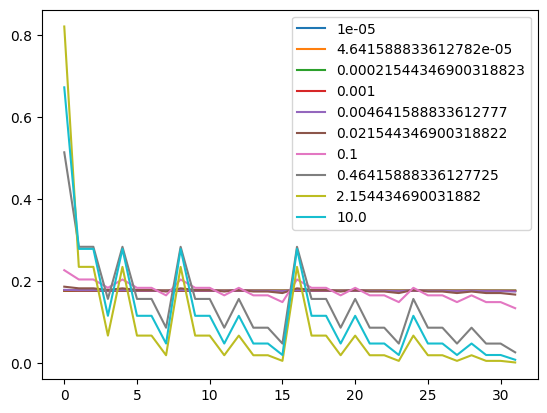

In [6]:
plt.figure()
for i in range(len(beta)):
    plt.plot(np.abs(tfd[i,:]), label=str(beta[i]))
    
plt.legend()


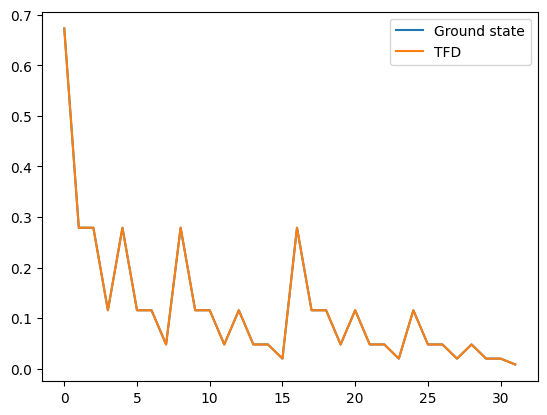

In [8]:
plt.figure()
plt.plot(np.abs(vecs.T[0]),label='Ground state')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()


## Exact Commutator

$|\sigma_{k+1} \rangle = e^{-s_k [\sigma_k, H]}|\sigma_k \rangle$

In [9]:
def commutator(A,B):
    """
    Commutator of two matrices A and B.
    """
    return A@B - B@A

def defaultStep(H):
    """
    Step size guaranteeing decrease $s = \frac{\Delta}{12\|H\|^3}$.
    """
    eigs = sp.linalg.eigvalsh(H)
    delta = eigs[1]-eigs[0] 
    norm = eigs[-1]
    s = delta/(12*norm**3)
    return s

def DBI(iters, H, step, state):
    """
    DBI iterations using the commutator with the Hamiltonian.
    """
    rho = np.outer(state, state.conj())
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0] = state
    for i in range(iters):
        rho = np.outer(newState[i], newState[i].conj())
        comm = commutator(rho, H)
        newState[i+1] = sp.linalg.expm(step*comm)@newState[i]
        newState[i+1] = newState[i+1]/np.sqrt(np.conj(newState[i+1])@newState[i+1])
    return newState

def UJFidelity(state1, state2):
    """
    Uhlmann-Josza fidelity between two states.
    """
    rho = np.outer(state1, state1.conj())
    sigma = np.outer(state2, state2.conj())
    return np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho)@sigma@sp.linalg.sqrtm(rho)))**2



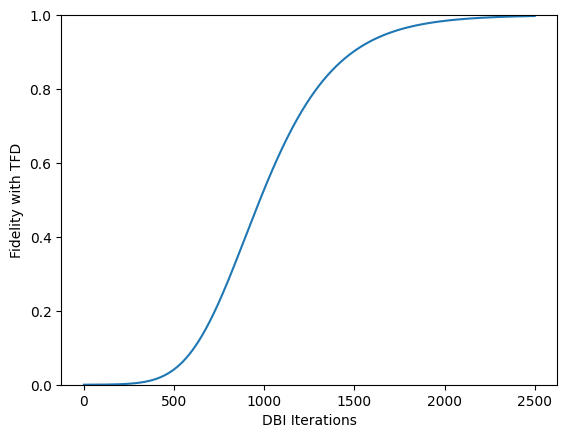

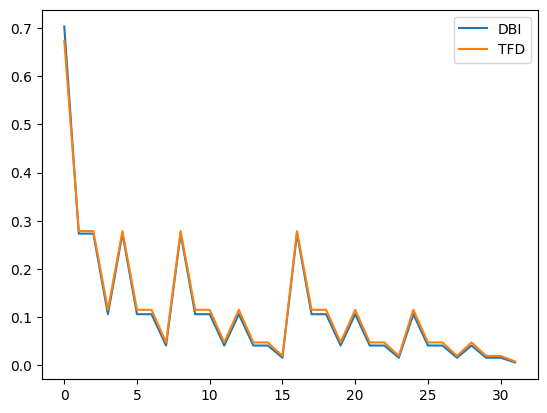

In [18]:
state = maxEntangledState(nqubits)
step = defaultStep(H)
iters = 2500

newState = DBI(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DBI Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)
plt.show()


plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBI')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()



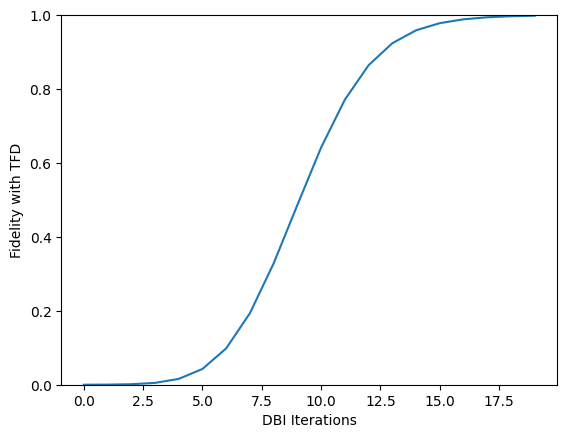

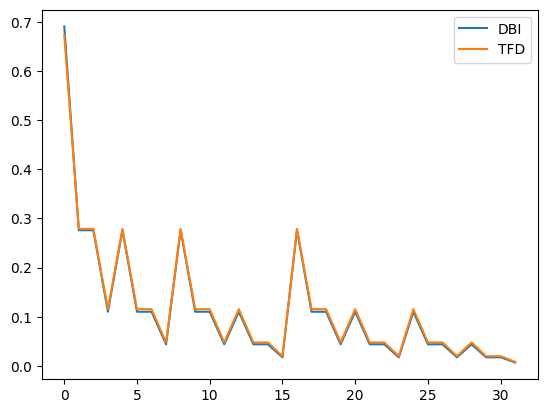

In [17]:
state = maxEntangledState(nqubits)
step = 0.1
iters = 20

newState = DBI(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DBI Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)
plt.show()


plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBI')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()



## Exact DB-QITE


$|\omega_{k+1} \rangle = e^{i\sqrt{s_k}H}e^{i\sqrt{s_k}\omega_k}e^{-i\sqrt{s_k}H}|\omega_k \rangle$

In [19]:
def reflectionOperator(state, step):
    """
    Reflection operator for the DBQITE algorithm.
    """
    rho = np.outer(state, state.conj())
    return sp.linalg.expm(1j*step*rho)

def unitaryRecursion(ham, refOperator, step):
    """
    Unitary recursion for the DBQITE algorithm.
    """
    U = sp.linalg.expm(1j*step*ham) @ refOperator @ sp.linalg.expm(-1j*step*ham)
    return U

def DBQITE(iters, H, step, state):
    """
    DBQITE algorithm.
    """
    ref = reflectionOperator(state, step)
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0,:] = state
    for i in range(iters):
        ref = reflectionOperator(newState[i,:], step)
        U = unitaryRecursion(H, ref, step)
        newState[i+1,:] = U@newState[i,:]
        newState[i+1,:] = newState[i+1,:]/np.sqrt(np.conj(newState[i+1,:])@newState[i+1,:])
    return newState



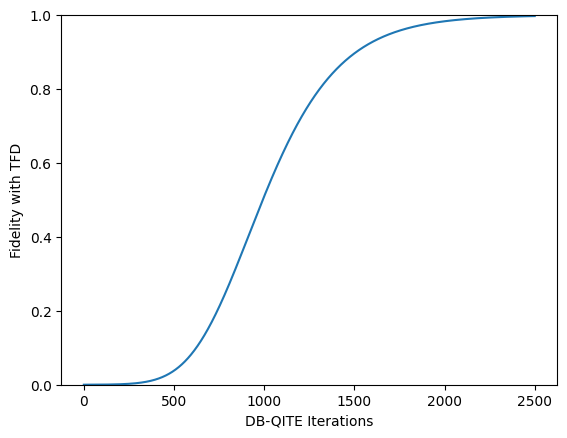

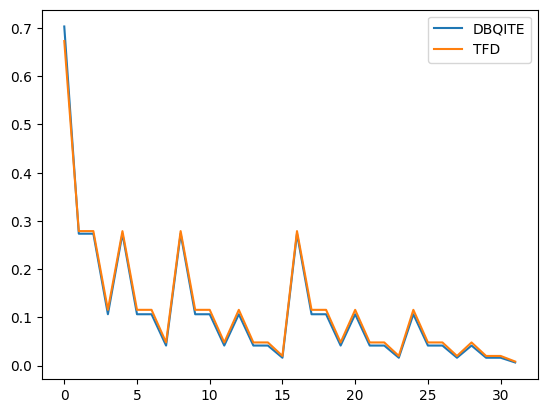

In [20]:
state = maxEntangledState(nqubits)
step = np.sqrt(defaultStep(H))
iters = 2500

newState = DBQITE(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DB-QITE Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)

plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBQITE')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()



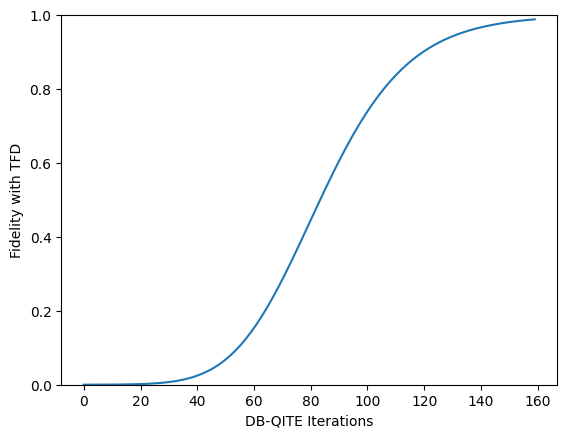

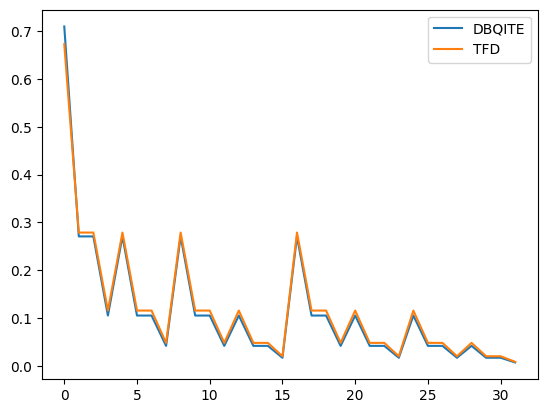

In [25]:
state = maxEntangledState(nqubits)
step = 0.1
iters = 160

newState = DBQITE(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DB-QITE Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)



plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBQITE')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()



## Comparison for different betas

In [26]:
def thermalStatePrepComparison(beta, H, nqubits, method, step = None):
    initState = maxEntangledState(nqubits)
    tfd = TFD(beta, H, initState)
    if method == 'DBI':
        if step is None:
            step = defaultStep(H)
        iters = int(beta/(2*step))
        newState = DBI(iters, H, step, initState)
    elif method == 'DBQITE':
        if step is None:
            step = np.sqrt(defaultStep(H))
            iters = int(beta/(2*step**2))
        else:
            iters = int(beta/(2*step))
        newState = DBQITE(iters, H, step, initState)
    fidelity = np.abs(UJFidelity(tfd, newState[-1,:]))

    return fidelity

In [30]:
beta = np.logspace(-2, 1, 100)
fidelityDBI = np.zeros(len(beta))
fidelityDBQITE = np.zeros(len(beta))
for i in tqdm(range(len(beta))):
    fidelityDBI[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBI')
    fidelityDBQITE[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE')

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


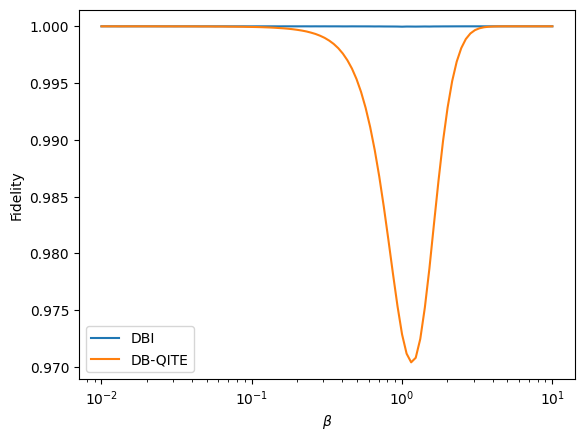

In [31]:
plt.figure()
plt.plot(beta, fidelityDBI, label='DBI')
plt.plot(beta, fidelityDBQITE, label='DB-QITE')
plt.ylabel('Fidelity')
plt.xlabel(r'$\beta$')
plt.xscale('log')
plt.legend()


In [36]:
beta = np.logspace(-2, 1, 50)
steps = np.logspace(-3, 0, 50)
fidelityDBI = np.zeros((len(beta),len(steps)))
fidelityDBQITE = np.zeros((len(beta),len(steps)))
for i in tqdm(range(len(beta))):
    for j in range(len(steps)):
        fidelityDBI[i,j] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBI',step=steps[j])
        fidelityDBQITE[i,j] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE',step=steps[j])

100%|██████████| 50/50 [04:17<00:00,  5.14s/it]


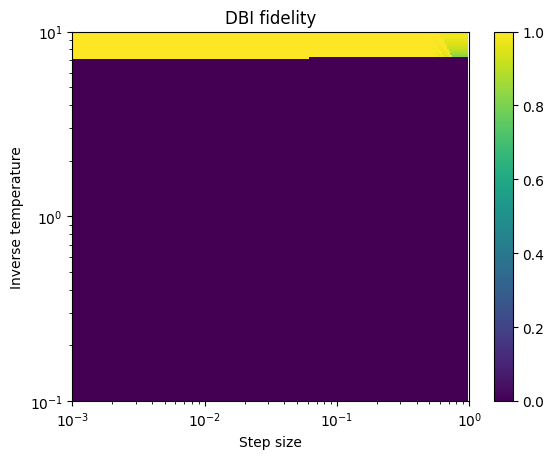

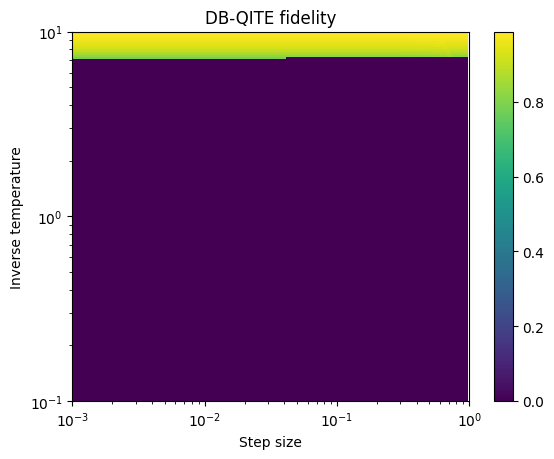

0.0006666666666666671


In [34]:
plt.figure()
plt.imshow(fidelityDBI, extent=[steps[0], steps[-1], beta[0], beta[-1]], aspect='auto')
plt.colorbar()
plt.xlabel('Step size')
plt.ylabel('Inverse temperature')
plt.yscale('log')
plt.xscale('log')
plt.title('DBI fidelity')
plt.show()

plt.figure()
plt.imshow(fidelityDBQITE, extent=[steps[0], steps[-1], beta[0], beta[-1]], aspect='auto')
plt.colorbar()
plt.xlabel('Step size')
plt.ylabel('Inverse temperature')
plt.yscale('log')
plt.xscale('log')
plt.title('DB-QITE fidelity')
plt.show()

print(defaultStep(H))